# ECSE415 - Intro to Computer Vision
## Tutorial 2 - Image Processing in OpenCV

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# make path = './' in-case you are running this locally
path = '/content/drive/My Drive/ECSE_415_F_2021/Tutorial_3/'


Mounted at /content/drive


# Image Gradients and Canny Edge Detection

## Image Gradients: cv2.Sobel()
https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#sobel

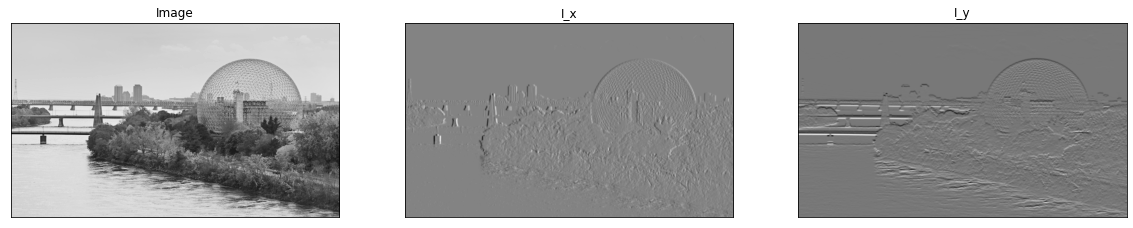

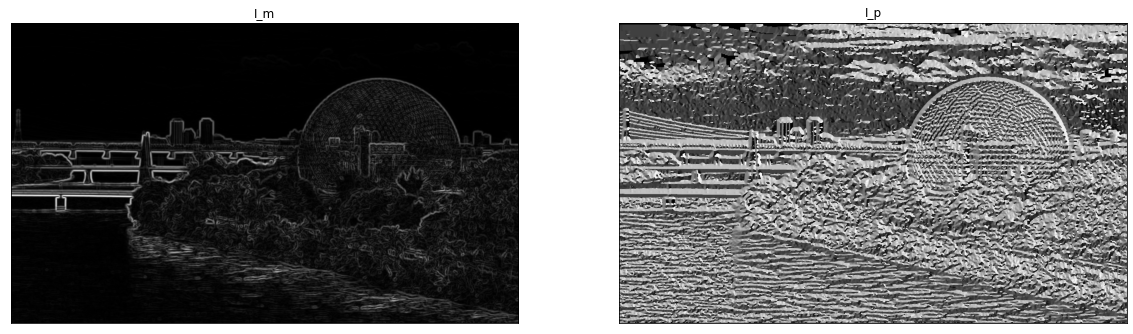

In [2]:
###################
# IMAGE GRADIENTS #
###################

import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

# store image path
img_path = path+"biosphere.jpg"

# load the image as grayscale
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# apply 15x15 Sobel filters to the intensity channel
I_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=21)
I_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=21)

# compute sobel Magnitude/Phase
I_m = cv2.magnitude(I_x, I_y)
I_p = cv2.phase(I_x, I_y)

# display images
plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(img, cmap="gray")
plt.title("Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(I_x, cmap="gray")
plt.title("I_x"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(I_y, cmap="gray")
plt.title("I_y"), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(I_m, cmap="gray")
plt.title("I_m"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(I_p, cmap="gray")
plt.title("I_p"), plt.xticks([]), plt.yticks([])
plt.show()

# Canny Edge Detection

### Numpy Implementation

###### Reference: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123


The Canny edge detection algorithm is composed of 5 steps:
1) Noise reduction;
2) Gradient calculation;
3) Non-maximum suppression;
4) Double threshold;
5) Edge Tracking by Hysteresis.


In [3]:
# store image path
img_path = path+"Rabbit.jpeg"

# load the image as grayscale
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)


### 1) Noise Reduction using Gaussian Filtering

#### Detour on Filtering

Mean Squared Error:  4161600.0


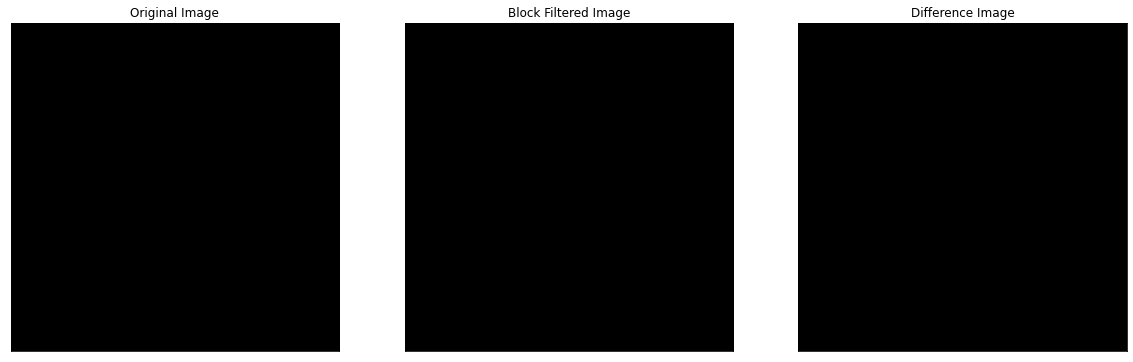

In [6]:
block_filter = (1/9)*np.array([[1,1,1],[1,1,1],[1,1,1]])

# block_filter = np.array([[1,1,1],[1,1,1],[1,1,1]])

constant_image = 255*np.ones((10,10))

filtered_image = cv2.filter2D(constant_image, cv2.CV_64F, block_filter)

mse = np.mean((constant_image-filtered_image)**2)
print("Mean Squared Error: ", mse)

plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(constant_image, cmap="gray")
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(filtered_image, cmap="gray")
plt.title("Block Filtered Image"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(constant_image-filtered_image, cmap="gray")
plt.title("Difference Image"), plt.xticks([]), plt.yticks([])
plt.show()




### Let's get back to canny edge detection

In [17]:
def gaussian_kernel(size, sigma=1):
    '''
    param: size - size of gaussian kernel (square kernel)
           sigma - sigma for gaussain (default - 1)
    '''
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    
    # normalize the kernel -- but why? -- didn't we just normalized it with normal variable
    # g = g / np.sum(g)

    return g, x, y
    # return g

X-Grid:  [[-2 -2 -2 -2 -2]
 [-1 -1 -1 -1 -1]
 [ 0  0  0  0  0]
 [ 1  1  1  1  1]
 [ 2  2  2  2  2]]
Y-grid:  [[-2 -1  0  1  2]
 [-2 -1  0  1  2]
 [-2 -1  0  1  2]
 [-2 -1  0  1  2]
 [-2 -1  0  1  2]]
Gaussian Kernel:  [[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]
Gaussian Kernel sum:  1.0


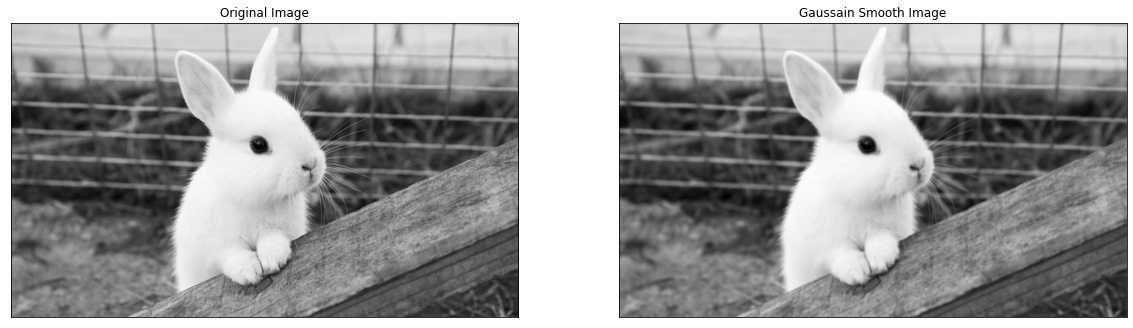

In [16]:
# get 5x5 gaussain kernel with sigma=1 
gauss_kernel, x, y = gaussian_kernel(5,1)
print("X-Grid: ", x)
print("Y-grid: ", y)
print("Gaussian Kernel: ", gauss_kernel)
print("Gaussian Kernel sum: ", np.sum(gauss_kernel))
# apply convolution using cv2.filter2D
img_gauss = cv2.filter2D(img, cv2.CV_64F, gauss_kernel)


# display original and gaussian smoothed image
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img, cmap="gray")
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_gauss, cmap="gray")
plt.title("Gaussain Smooth Image"), plt.xticks([]), plt.yticks([])
plt.show()

### 2) Gradient Calculation using Sobel Operation

In [18]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = cv2.filter2D(img_gauss, cv2.CV_64F, Kx)
    Iy = cv2.filter2D(img_gauss, cv2.CV_64F, Ky)
        
    # compute sobel Magnitude/Phase
    Im = cv2.magnitude(Ix, Iy)
    Im = Im / Im.max() * 255
    Ip = cv2.phase(Ix, Iy)    

    return (Im, Ip)

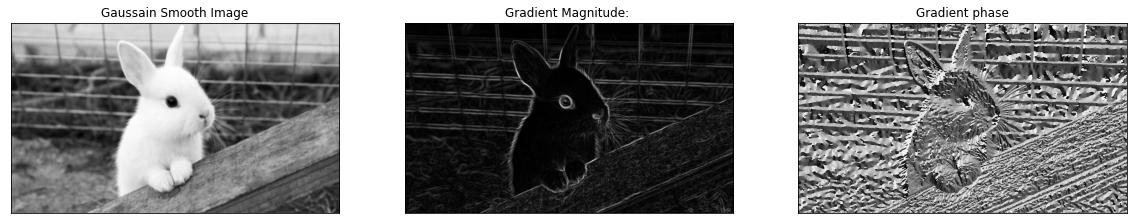

In [19]:
img_mag, img_phs = sobel_filters(img_gauss)

# display images
plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(img_gauss, cmap="gray")
plt.title("Gaussain Smooth Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(img_mag, cmap="gray")
plt.title("Gradient Magnitude: "), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img_phs, cmap="gray")
plt.title("Gradient phase"), plt.xticks([]), plt.yticks([])
plt.show()

### 3) Non Maximum Suppresion

Each pixel has 2 main criteria (edge direction in radians, and pixel intensity (between 0–255)). Based on these inputs the non-max-suppression steps are:

1) Create a matrix initialized to 0 of the same size of the original gradient intensity matrix;

2) Identify the edge direction based on the angle value from the angle matrix;

3) Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed;

4) Return the image processed with the non-max suppression algorithm.

In [ ]:
def non_max_suppression(img_mag, img_phs):
    
    M, N = img_mag.shape
    Z = np.zeros((M,N), dtype=np.int32)
    
    # convert img_phs (radian) into angle image
    img_angle = img_phs * 180. / np.pi
    img_angle[img_angle < 0] += 180

    
    for i in range(1,M-1): # Note that we are leaving 1 pixel gap on each side of image
        for j in range(1,N-1): # as for boundary pixels one of its neighbourhood pixel is not defined
            
            # store neighbourhood pixels in variables q and r
            q = 255
            r = 255

            #angle 0
            if (0 <= img_angle[i,j] < 22.5) or (157.5 <= img_angle[i,j] <= 180):
                q = img_mag[i, j+1]
                r = img_mag[i, j-1]
            #angle 45
            elif (22.5 <= img_angle[i,j] < 67.5):
                q = img_mag[i+1, j-1]
                r = img_mag[i-1, j+1]
            #angle 90
            elif (67.5 <= img_angle[i,j] < 112.5):
                q = img_mag[i+1, j]
                r = img_mag[i-1, j]
            #angle 135
            elif (112.5 <= img_angle[i,j] < 157.5):
                q = img_mag[i-1, j-1]
                r = img_mag[i+1, j+1]

            # if pixel magnitude is higher than both its neighbour than keep     
            if (img_mag[i,j] >= q) and (img_mag[i,j] >= r):
                Z[i,j] = img_mag[i,j]
            # otherwise make its value to 0
            else:
                Z[i,j] = 0
    
    return Z

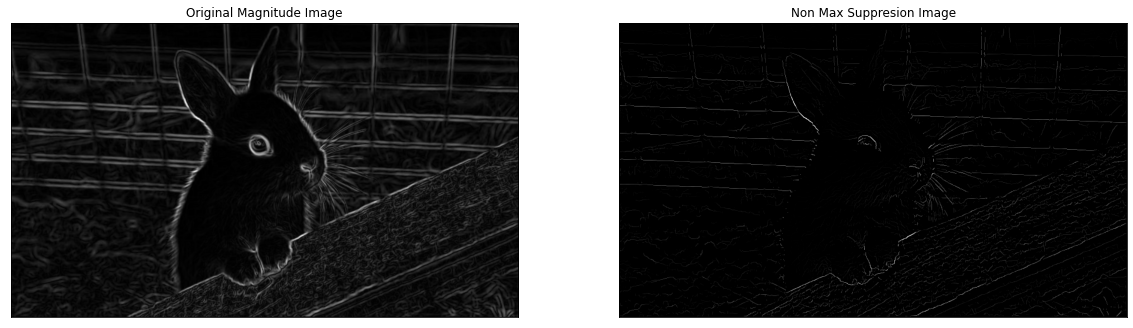

In [ ]:
img_nms =  non_max_suppression(img_mag, img_phs)

# display images
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img_mag, cmap="gray")
plt.title("Original Magnitude Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_nms, cmap="gray")
plt.title("Non Max Suppresion Image"), plt.xticks([]), plt.yticks([])
plt.show()

### 4) Double Threshold

The double threshold step aims at identifying 3 kinds of pixels: strong, weak, and non-relevant:

1) Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.

2) Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.

3) Other pixels are considered as non-relevant for the edge.


#### Now you can see what the double thresholds holds for:

1) High threshold is used to identify the strong pixels (intensity higher than the high threshold)

2) Low threshold is used to identify the non-relevant pixels (intensity lower than the low threshold)

3) All pixels having intensity between both thresholds are flagged as weak and the Hysteresis mechanism (next step) will help us identify the ones that could be considered as strong and the ones that are considered as non-relevant.


In [ ]:
def threshold(img_nms, lowThresholdRatio=0.05, highThresholdRatio=0.09):

    # convert ratios into intensity values
    highThreshold = img_nms.max() * highThresholdRatio;
    lowThreshold = img_nms.max() * lowThresholdRatio;
    
    # define a result image similar size to input image
    res = np.zeros_like(img_nms)
    
    # define intensity values for weak and strong image
    weak = np.int32(25)
    strong = np.int32(255)
    
    # do double thresholding
    res[img_nms>=highThreshold] = strong
    res[(img_nms<=highThreshold) & (img_nms>=lowThreshold)] = weak
    
    return (res, weak, strong)

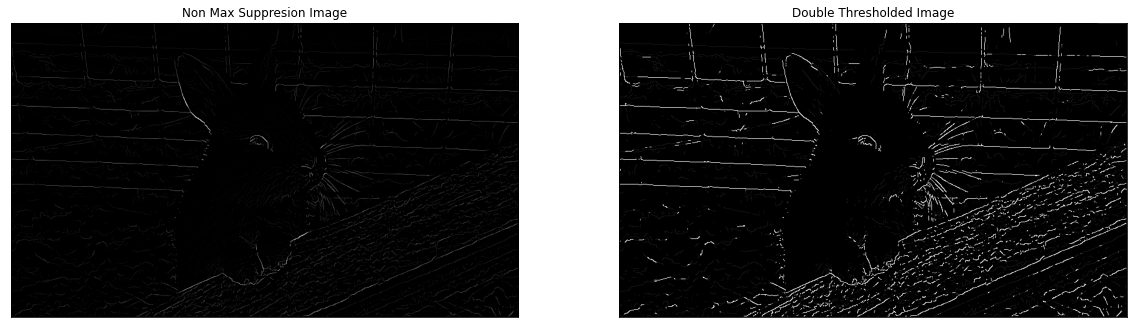

In [ ]:
img_dt, weak, strong =  threshold(img_nms, lowThresholdRatio=0.05, highThresholdRatio=0.12)

# display images
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img_nms, cmap="gray")
plt.title("Non Max Suppresion Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_dt, cmap="gray")
plt.title("Double Thresholded Image"), plt.xticks([]), plt.yticks([])
plt.show()

### 5) Edge Tracking by Hystersis

Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one.

In [ ]:
def hysteresis(img_dt, weak, strong=255):
    M, N = img_dt.shape
    
    
    # start at top left
    for i in range(1, M-1): 
        for j in range(1, N-1):
            
            # do not process strong edge pixels
            if (img_dt[i,j] == weak):
            
                if ((img_dt[i+1, j-1] == strong) # top left
                    or (img_dt[i+1, j] == strong) # top middle
                    or (img_dt[i+1, j+1] == strong) # top right
                    or (img_dt[i, j-1] == strong) # middle left
                    or (img_dt[i, j+1] == strong) # middle right
                    or (img_dt[i-1, j-1] == strong) # bottom left
                    or (img_dt[i-1, j] == strong) # bottom middle
                    or (img_dt[i-1, j+1] == strong)): # bottom right
                    
                    img_dt[i, j] = strong

    # start at top right
    for i in range(M-2, 0, -1): # Note: in range(start, end) - start is inclusive but end is not
                                # range goes from start till one before end
                                # -1 indicates that range is in decreasing order with -1.
        for j in range(1, N-1):
            
            # do not process strong edge pixels
            if (img_dt[i,j] == weak):
            
                if ((img_dt[i+1, j-1] == strong) # top left
                    or (img_dt[i+1, j] == strong) # top middle
                    or (img_dt[i+1, j+1] == strong) # top right
                    or (img_dt[i, j-1] == strong) # middle left
                    or (img_dt[i, j+1] == strong) # middle right
                    or (img_dt[i-1, j-1] == strong) # bottom left
                    or (img_dt[i-1, j] == strong) # bottom middle
                    or (img_dt[i-1, j+1] == strong)): # bottom right
                    
                    img_dt[i, j] = strong

                    
    # start at bottom left
    for i in range(1, M-1):
        for j in range(N-2, 0, -1):
            
            # do not process strong edge pixels
            if (img_dt[i,j] == weak):
            
                if ((img_dt[i+1, j-1] == strong) # top left
                    or (img_dt[i+1, j] == strong) # top middle
                    or (img_dt[i+1, j+1] == strong) # top right
                    or (img_dt[i, j-1] == strong) # middle left
                    or (img_dt[i, j+1] == strong) # middle right
                    or (img_dt[i-1, j-1] == strong) # bottom left
                    or (img_dt[i-1, j] == strong) # bottom middle
                    or (img_dt[i-1, j+1] == strong)): # bottom right
                    
                    img_dt[i, j] = strong

    # start at bottom right
    for i in range(M-2, 0, -1):
        for j in range(N-2, 0, -1):
            
            # do not process strong edge pixels
            if (img_dt[i,j] == weak):
            
                if ((img_dt[i+1, j-1] == strong) # top left
                    or (img_dt[i+1, j] == strong) # top middle
                    or (img_dt[i+1, j+1] == strong) # top right
                    or (img_dt[i, j-1] == strong) # middle left
                    or (img_dt[i, j+1] == strong) # middle right
                    or (img_dt[i-1, j-1] == strong) # bottom left
                    or (img_dt[i-1, j] == strong) # bottom middle
                    or (img_dt[i-1, j+1] == strong)): # bottom right
                    
                    img_dt[i, j] = strong
            
                else:

                    img_dt[i,j] = 0
                    
    return img_dt

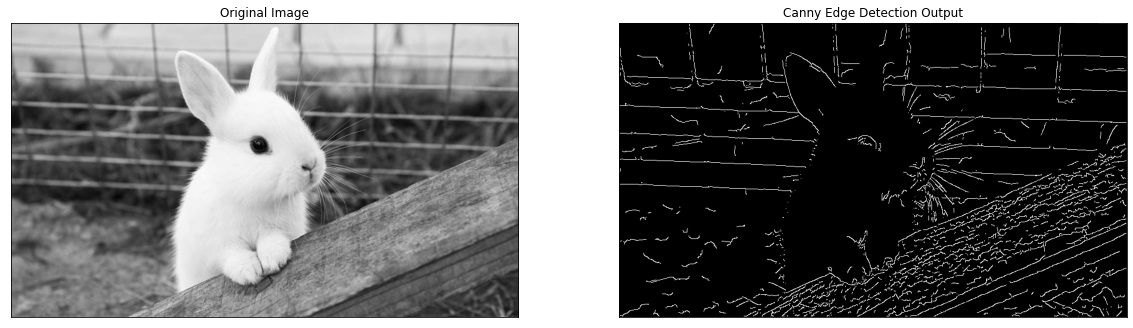

In [ ]:
img_edge =  hysteresis(img_dt, weak, strong)

# display images
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img, cmap="gray")
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_edge, cmap="gray")
plt.title("Canny Edge Detection Output"), plt.xticks([]), plt.yticks([])
plt.show()

## OpenCV function for Canny Edge detection

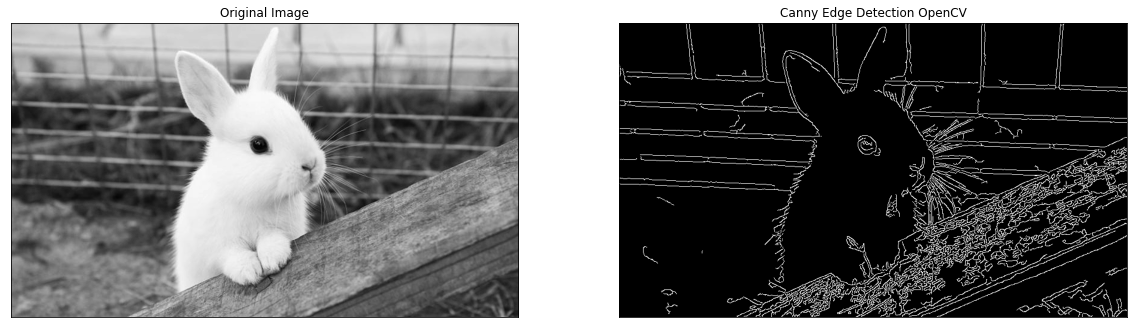

In [ ]:
##################
# EDGE DETECTION #
##################


# https://docs.opencv.org/trunk/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de
# Canny(InputArray  --> image,
#       OutputArray --> edges,
#       double      --> threshold1,
#       double      --> threshold2,
#       int         --> apertureSize = 3,
#       bool        --> L2gradient = false 

img_gauss = cv2.GaussianBlur(img, (7, 7), 1)
img_edge_cv = cv2.Canny(img_gauss, 10, 120)

# display images
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img, cmap="gray")
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_edge_cv, cmap="gray")
plt.title("Canny Edge Detection OpenCV"), plt.xticks([]), plt.yticks([])
plt.show()

# Harris Corner Detection

Before Normalization
-0.04
0.08114351


After Normalization
0.0
2.0


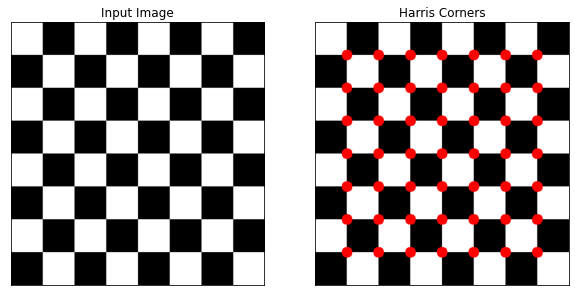

In [ ]:
##########################
# HARRIS CORNER DETECTOR #
##########################

# load image as grayscale
img = cv2.imread(path+"chessboard.png")

# copy image
img_disp = img.copy()

# convert to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# detect harris corners
# cv2.cornerHarris(src, neighborhoodsize, sobelKernelSize, Harris_k)
corners = cv2.cornerHarris(img_gray, 2, 3, 0.04)

print("Before Normalization")
print(np.min(corners))
print(np.max(corners))

# normalize corner map [0,1]
# cv2.normalize(src, dst, alpha, beta, norm_type)
# min_I(dst(I)) = alpha, max_I(dst(I)) = beta
cv2.normalize(corners, corners, 0, 2, cv2.NORM_MINMAX)

print("\n\nAfter Normalization")
print(np.min(corners))
print(np.max(corners))

# threshold for an optimal value
thres = 1.0

# list all points higher than threshold
loc = np.where(corners >= thres)

# loop though points
for pt in zip(*loc[::-1]):
    # draw filled circle on each point
    # cv2.circle(img, center, radius, color[, thickness[, lineType[, shift]]]) → None
    cv2.circle(img_disp, pt, 15, (255,0,0), -1)

# display images
plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(img)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_disp)
plt.title("Harris Corners"), plt.xticks([]), plt.yticks([])
plt.show()